# Explore metadata for S1 RTC in any given MGRS Square

10TEK

In [1]:
import os
os.environ['JUPYTER_IMAGE']

'pcccr.azurecr.io/public/planetary-computer/python:2022.9.16.0'

In [2]:
import folium
import fsspec
import geopandas as gpd
import odc
import odc.stac
import pystac_client
import planetary_computer

In [3]:
# Heat map of coverage
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_image
from functools import partial
from rasterio.enums import MergeAlg

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [4]:
%config InlineBackend.figure_format='retina'

In [5]:
%%time
url = 'https://github.com/scottyhq/mgrs/raw/main/MGRS_LAND.parquet'
with fsspec.open(url) as file:
    gf = gpd.read_parquet(file)

CPU times: user 161 ms, sys: 47 ms, total: 208 ms
Wall time: 968 ms


In [6]:
gf.head()

,tile,geometry,epsg,utm_wkt,utm_bounds
0,01KAB,"POLYGON ((180.00000 -17.25048, 179.23921 -17.2...",32701,"POLYGON ((99960 8200000,99960 8090200,209760 8...","(99960.0, 8090200.0, 209760.0, 8200000.0)"
1,01LAC,"POLYGON ((180.00000 -16.34738, 179.25695 -16.3...",32701,"POLYGON ((99960 8300020,99960 8190220,209760 8...","(99960.0, 8190220.0, 209760.0, 8300020.0)"
2,01LBC,"POLYGON ((-179.79445 -15.35907, -178.77220 -15...",32701,"POLYGON ((199980 8300020,199980 8190220,309780...","(199980.0, 8190220.0, 309780.0, 8300020.0)"
3,01VCK,"POLYGON ((180.00000 62.10763, 179.16853 62.090...",32601,"POLYGON ((300000 7000020,300000 6890220,409800...","(300000.0, 6890220.0, 409800.0, 7000020.0)"
4,01VCL,"POLYGON ((180.00000 63.00584, 179.05150 62.986...",32601,"POLYGON ((300000 7100040,300000 6990240,409800...","(300000.0, 6990240.0, 409800.0, 7100040.0)"


In [7]:
MGRS_TILE = "10TEK"
aoi = gf.query(' tile == @MGRS_TILE ') # returns a geodataframe
#aoi = gf[gf.tile == MGRS_TILE]
aoi.explore()

In [8]:
s = aoi.iloc[0] #geoseries

GEOMETRY = s.geometry.__geo_interface__
EPSG = str(s.epsg)

In [9]:
stac_client = pystac_client.Client.open('https://planetarycomputer.microsoft.com/api/stac/v1',
                                        modifier = planetary_computer.sign_inplace,
                                       )

In [10]:
%%time

search = stac_client.search(
    collections = ['sentinel-1-rtc'],
    intersects = GEOMETRY,
    #datetime = '2021-08-01/2022-08-05',
    query={"proj:epsg": {"eq": EPSG}}, 
)

items = search.get_all_items()
print(f'Returned {len(items)} items')

Returned 1728 items
CPU times: user 843 ms, sys: 62.4 ms, total: 906 ms
Wall time: 5.3 s


In [11]:
gfs = gpd.GeoDataFrame.from_features( items.to_dict(), crs='EPSG:4326')

In [12]:
gfs['sat:relative_orbit'].value_counts()

137    517
42     441
115    418
35     350
139      2
Name: sat:relative_orbit, dtype: int64

In [13]:
# NOTE that 186 of these only have VV polarization
gfs['sar:polarizations'].value_counts()

[VV, VH]    1542
[VV]         186
Name: sar:polarizations, dtype: int64

In [14]:
gfs.loc[0,['sar:polarizations']].values

array([list(['VV', 'VH'])], dtype=object)

In [15]:
['VV'] == ['VV']

True

In [16]:
# Acquisitions with only VV
gfs[gfs['sar:polarizations'].apply(lambda x: x == ['VV'])]['sat:relative_orbit'].value_counts()

115    66
42     43
137    40
35     35
139     2
Name: sat:relative_orbit, dtype: int64

In [17]:
# https://geopandas.org/en/stable/docs/user_guide/interactive_mapping.html
orbits = gfs.dissolve(by='sat:relative_orbit').reset_index()

m = orbits.explore(tooltip=False,
                  column='sat:relative_orbit',
                  categorical=True,
                  cmap='rainbow',
                  style_kwds=dict(fill=False),
                  tiles="Esri.WorldImagery", 
                 )

mgrs = aoi.explore(m=m,
                   color='white')

folium.LayerControl().add_to(m)
m

In [18]:
# Heat Map
gfs['counts'] = 1

full_grid = make_geocube(
    vector_data=gfs,
    group_by = 'sat:relative_orbit', # FOR all acquisitions leave this
    measurements=['counts'],
    resolution=(0.01, 0.01),
    rasterize_function=partial(rasterize_image, merge_alg=MergeAlg.add), #, all_touched=True), #NOTE: consider difference with all_touched=True
    fill=0,
)

full_grid

<xarray.Dataset>
Dimensions:             (sat:relative_orbit: 5, y: 474, x: 641)
Coordinates:
  * y                   (y) float64 37.94 37.95 37.96 ... 42.65 42.66 42.67
  * x                   (x) float64 -125.0 -124.9 -124.9 ... -118.6 -118.6
  * sat:relative_orbit  (sat:relative_orbit) int64 35 42 115 137 139
    spatial_ref         int64 0
Data variables:
    counts              (sat:relative_orbit, y, x) float64 0.0 0.0 ... 0.0 0.0

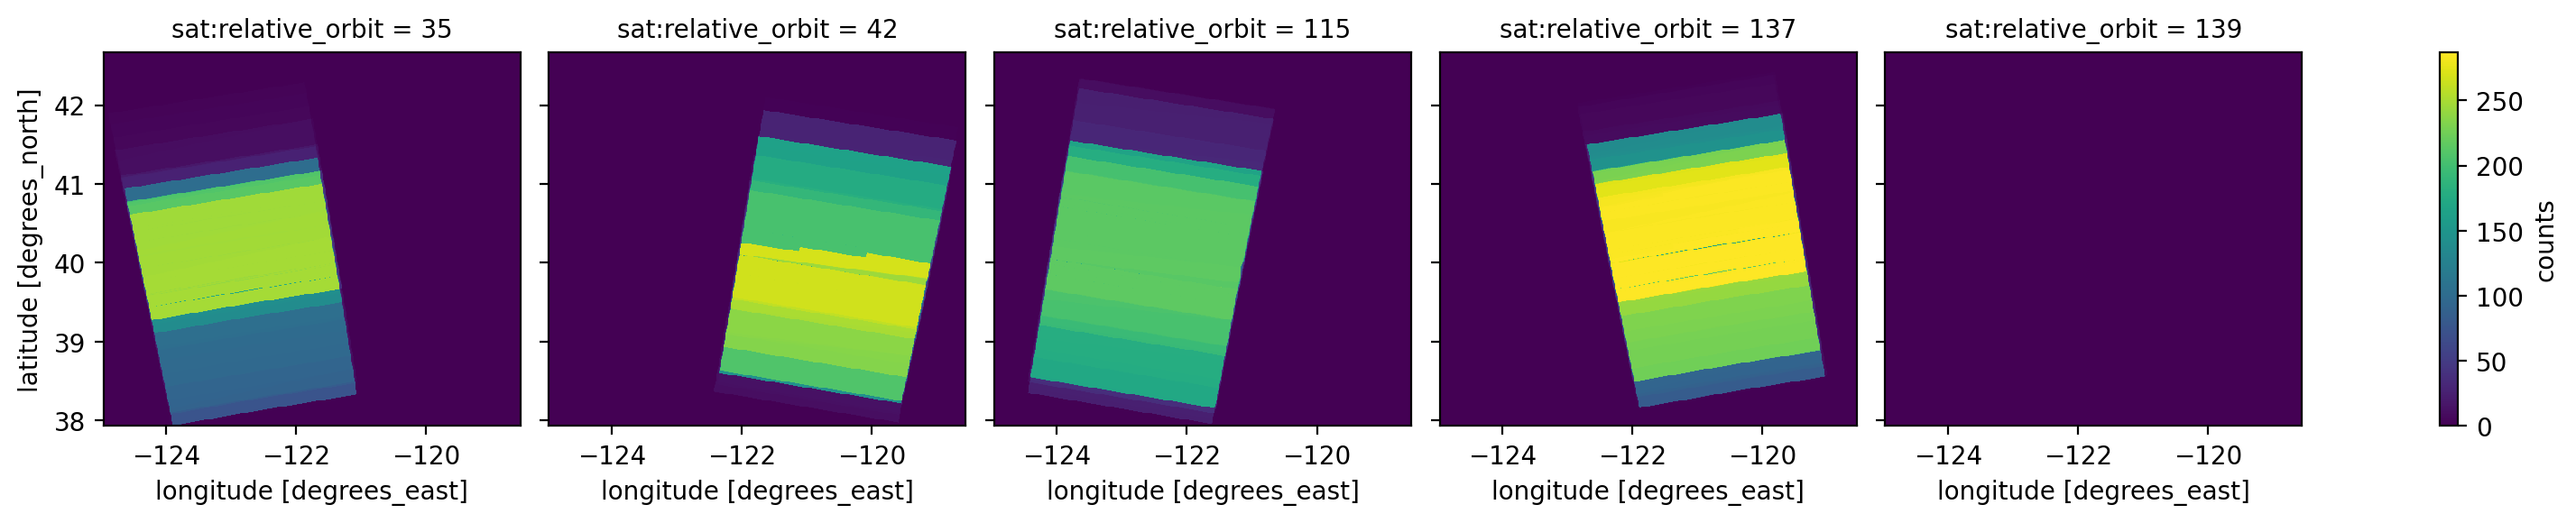

In [19]:
full_grid.counts.plot(col='sat:relative_orbit');

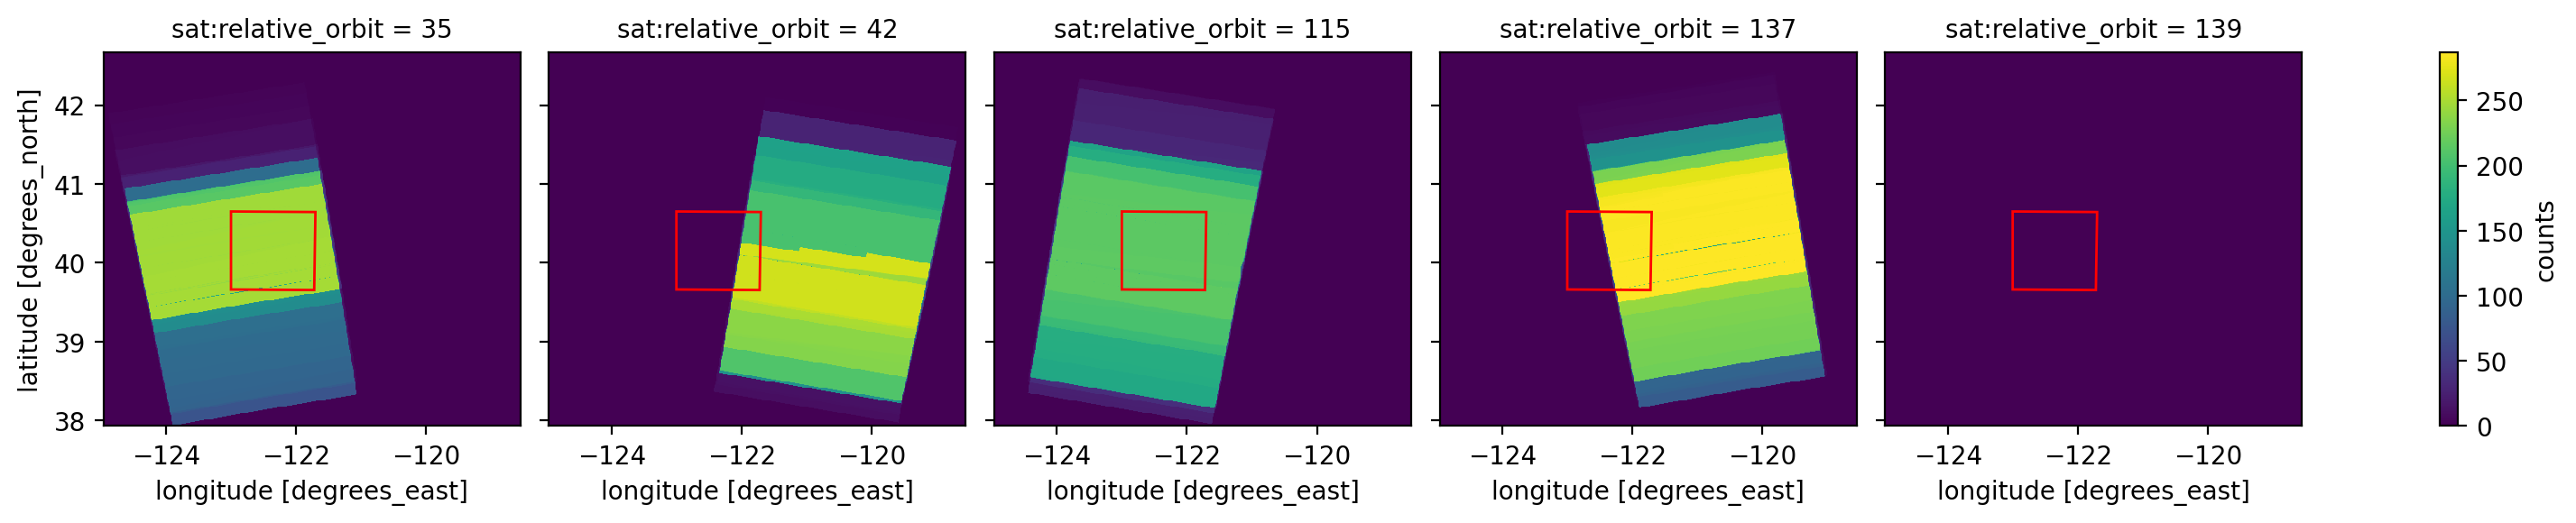

In [20]:
facet_grid = full_grid.counts.plot(col='sat:relative_orbit')

# Iterate over facet grid to modify:
for ax in facet_grid.axes.flatten():
    rect = patches.Polygon(list(s.geometry.boundary.coords), linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect);

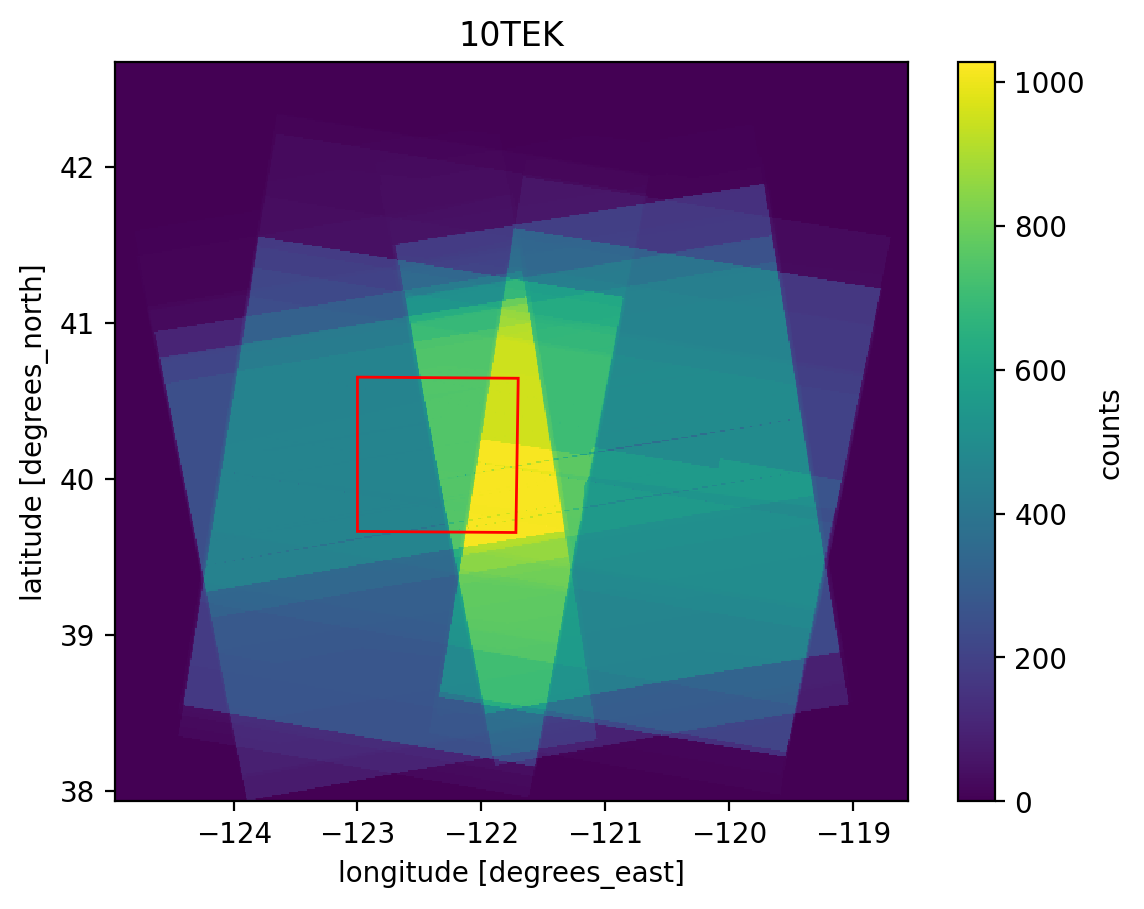

In [21]:
fig,ax = plt.subplots()

full_grid.sum(dim='sat:relative_orbit').counts.plot(ax=ax)

# Add AOI 
rect = patches.Polygon(list(s.geometry.boundary.coords), linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect);
ax.set_title(MGRS_TILE);

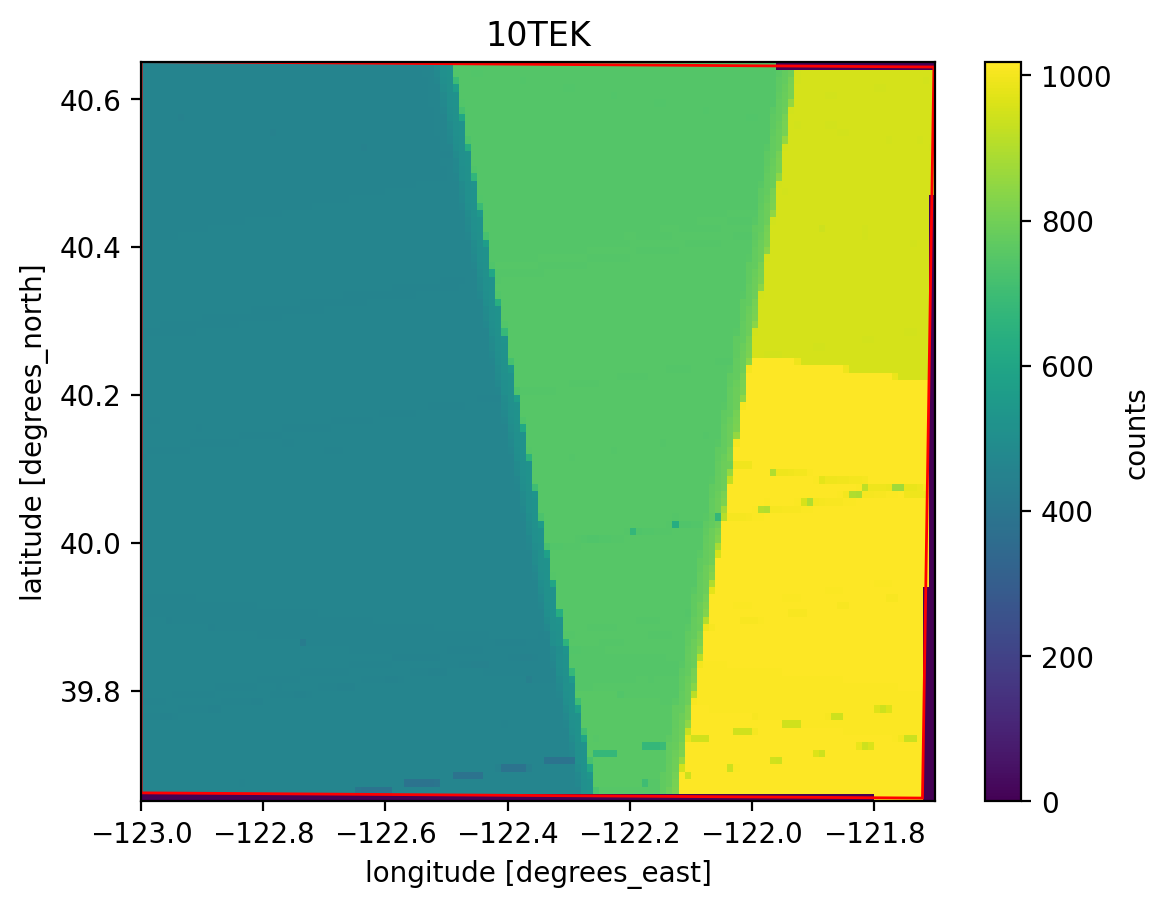

In [22]:
# CROP to MGRS Boundary
fig,ax = plt.subplots()

full_grid.rio.clip([GEOMETRY]).sum(dim='sat:relative_orbit').counts.plot(ax=ax)

# Add AOI 
rect = patches.Polygon(list(s.geometry.boundary.coords), linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect);
ax.set_title(MGRS_TILE);

FRAMES= 1728
ACQUISITION DATES= 849


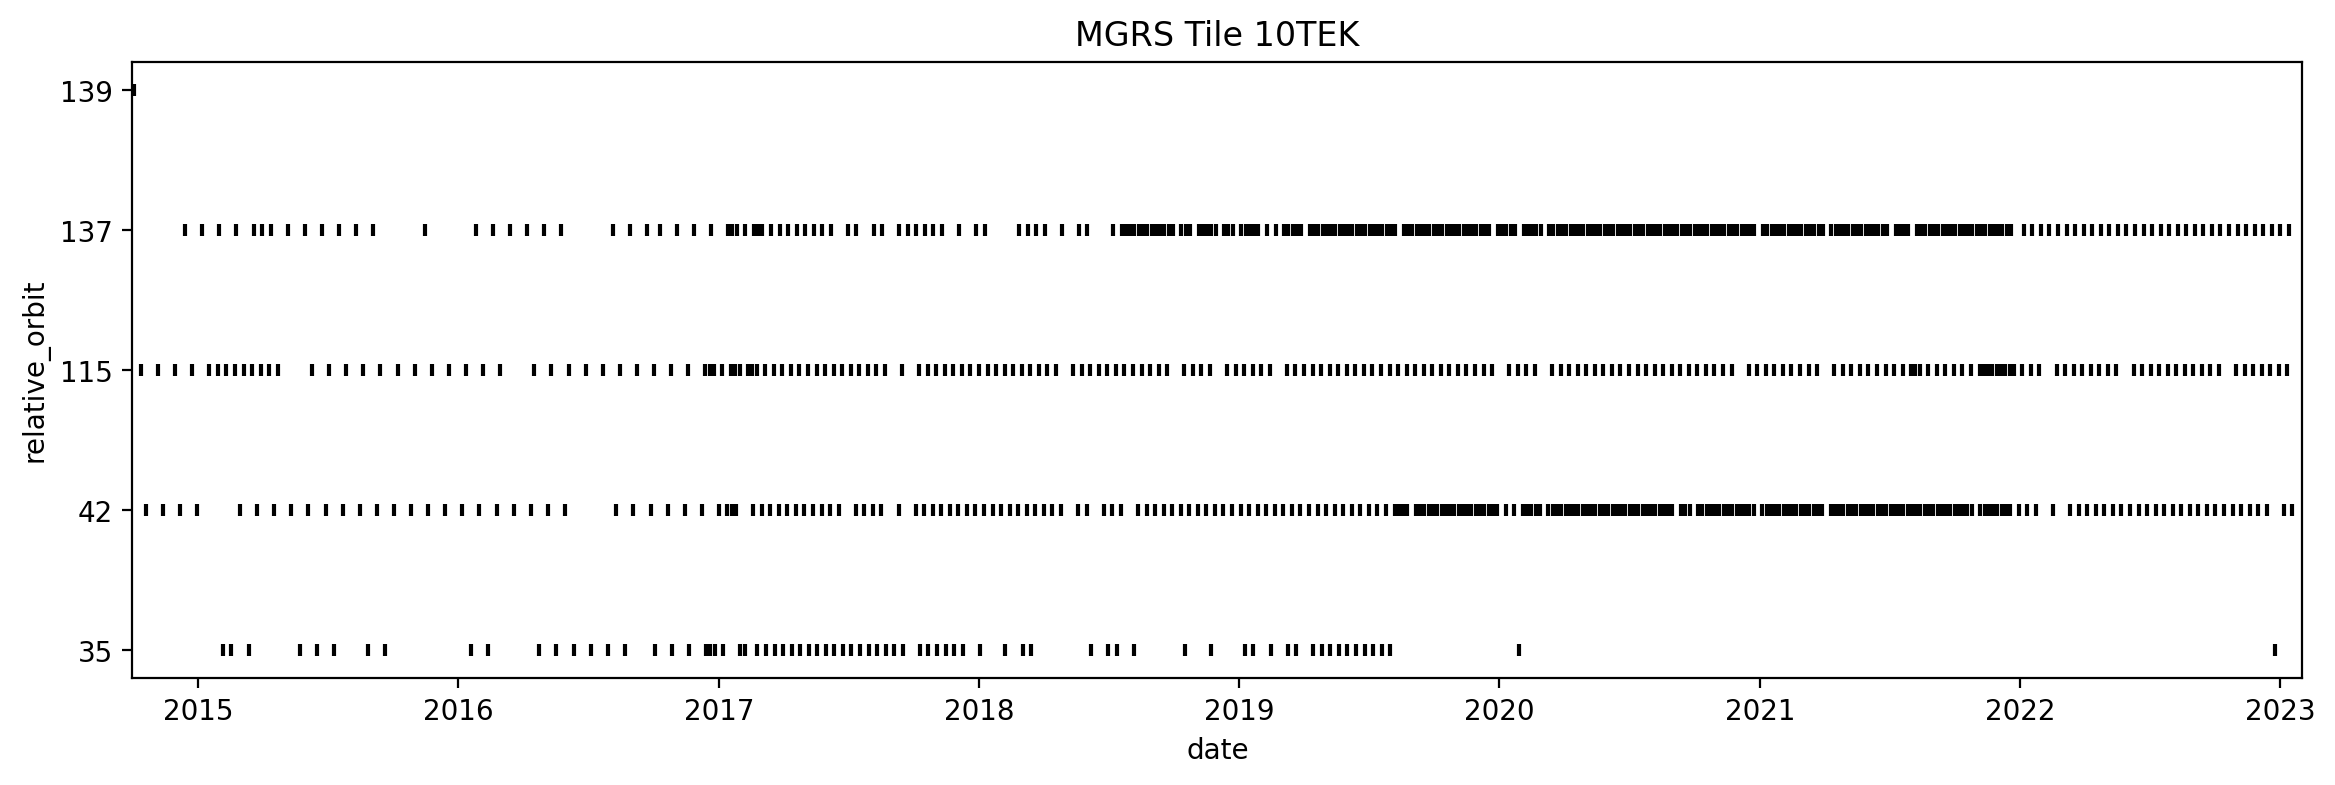

In [23]:
gpd.pd.options.mode.chained_assignment = None  # default='warn'

gfs['date'] = gpd.pd.to_datetime(gfs.datetime).dt.date
print(f'FRAMES= {len(gfs)}')
ts = gfs.drop_duplicates('date')
print(f'ACQUISITION DATES= {len(ts)}')
ts.sort_values('sat:relative_orbit', inplace=True)
ts['relative_orbit'] = ts['sat:relative_orbit'].astype(str)
ts.plot.scatter(x='date', y='relative_orbit', c='k', marker='|', figsize=(14,4));
plt.xlim(gpd.pd.to_datetime('10/2014'),gpd.pd.to_datetime('02/2023'))
plt.title(f'MGRS Tile {MGRS_TILE}');

FRAMES= 186
ACQUISITION DATES= 111


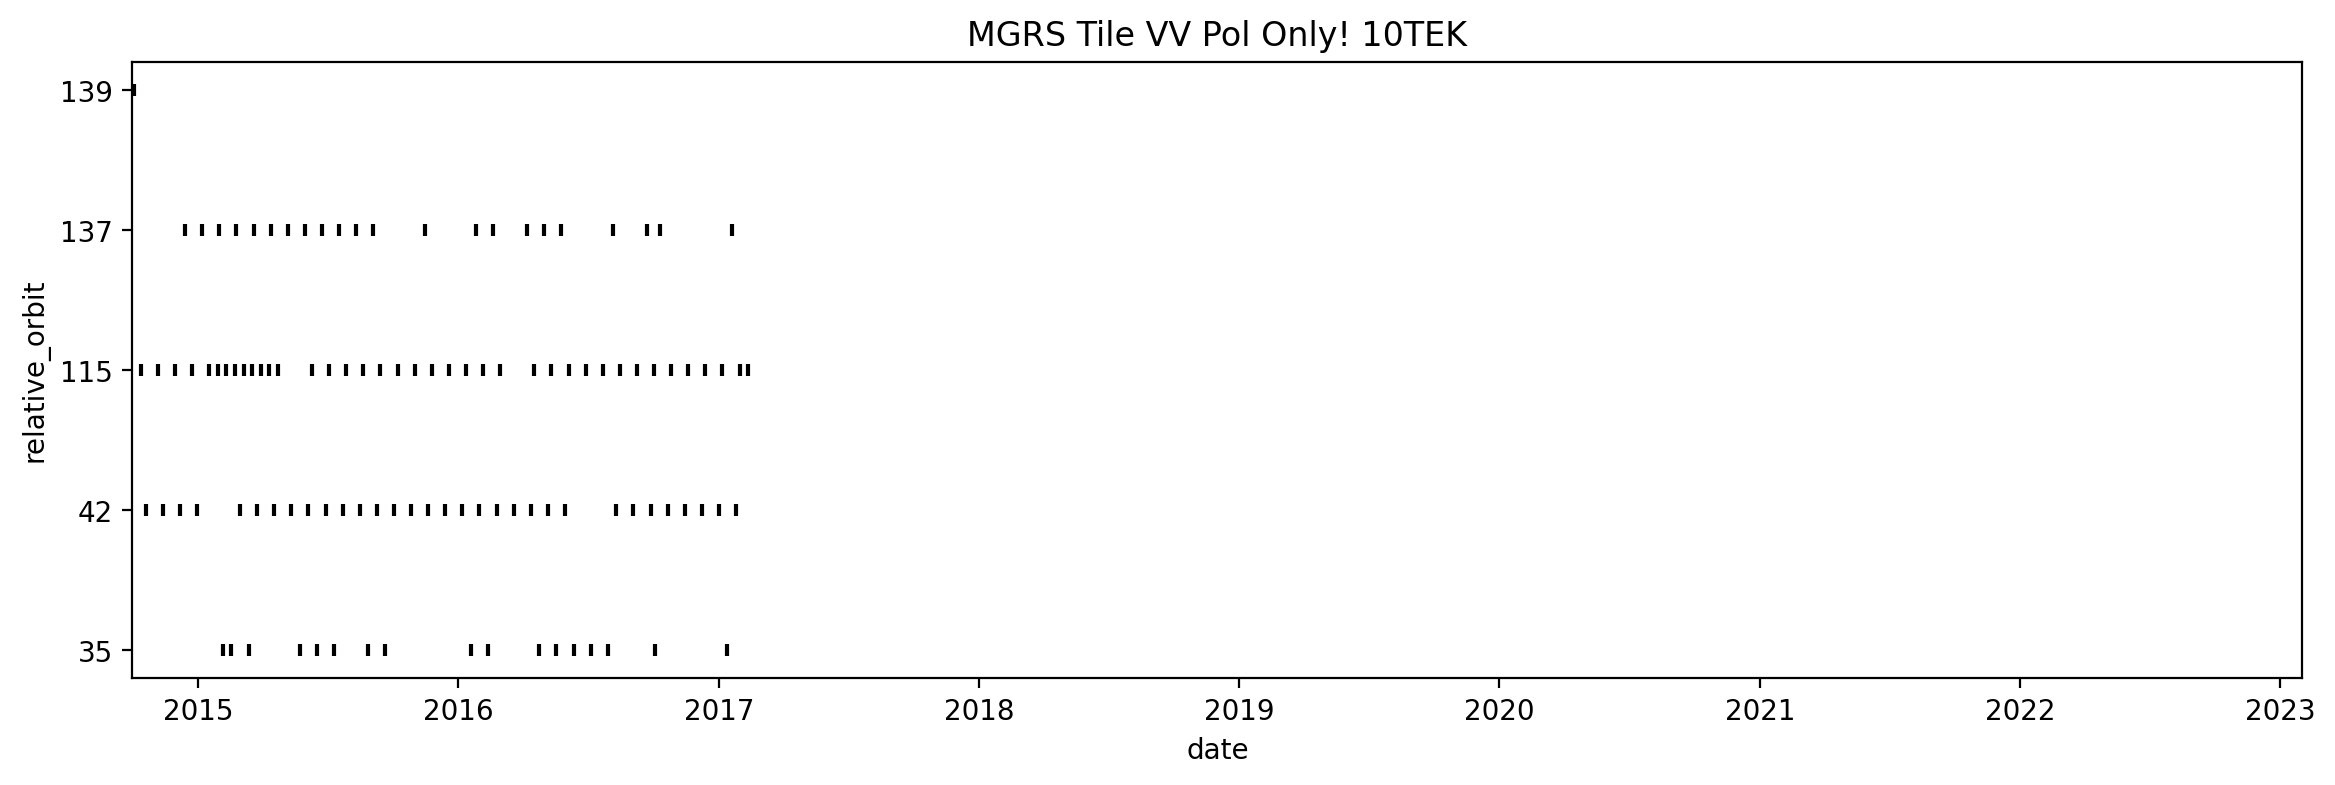

In [24]:
vv = gfs[gfs['sar:polarizations'].apply(lambda x: x == ['VV'])]

vv['date'] = gpd.pd.to_datetime(vv.datetime).dt.date
print(f'FRAMES= {len(vv)}')
ts = vv.drop_duplicates('date')
print(f'ACQUISITION DATES= {len(ts)}')
ts.sort_values('sat:relative_orbit', inplace=True)
ts['relative_orbit'] = ts['sat:relative_orbit'].astype(str)
ts.plot.scatter(x='date', y='relative_orbit', c='k', marker='|', figsize=(14,4));
plt.xlim(gpd.pd.to_datetime('10/2014'),gpd.pd.to_datetime('02/2023'))
plt.title(f'MGRS Tile VV Pol Only! {MGRS_TILE}'); # NOTE different time range from above!